# Multi-table Datasets - ENRON Archive

## 1. Data import

Connect to the file 'assets/datasets/enron.db' using one of these methods:

- sqlite3 python package
- pandas.read_sql
- SQLite Manager Firefox extension

Take a look at the database and query the master table. How many Tables are there in the db?

> Answer:
There are 3 tables:
- MessageBase
- RecipientBase
- EmployeeBase

In [2]:
import pandas as pd
from pandas.io import sql as pdsql
import sqlite3
conn = sqlite3.connect('../../assets/datasets/enron.db')
#pdconn = pdsql.("../../assets/datasets/enron.db")

Query the `sqlite_master` table to retrieve the schema of the `EmployeeBase` table.

1. What fields are there?
1. What's the type of each of them?

In [3]:
pdsql.read_sql(
    '''  pragma table_info(EmployeeBase)
    ''',con=conn)

,cid,name,type,notnull,dflt_value,pk
0,0,eid,INTEGER,0,None,0
1,1,name,TEXT,0,None,0
2,2,department,TEXT,0,None,0
3,3,longdepartment,TEXT,0,None,0
4,4,title,TEXT,0,None,0
5,5,gender,TEXT,0,None,0
6,6,seniority,TEXT,0,None,0


1. Print the first 5 rows of EmployeeBase table
1. Print the first 5 rows of MessageBase table
1. Print the first 5 rows of RecipientBase table

**Hint**  use `SELECT` and `LIMIT`.

In [4]:
pdsql.read_sql('''
select * 
from EmployeeBase 
limit 5
'''
,con=conn)

,eid,name,department,longdepartment,title,gender,seniority
0,1,John Arnold,Forestry,ENA Gas Financial,VP Trading,Male,Senior
1,2,Harry Arora,Forestry,ENA East Power,VP Trading,Male,Senior
2,3,Robert Badeer,Forestry,ENA West Power,Mgr Trading,Male,Junior
3,4,Susan Bailey,Legal,ENA Legal,Specialist Legal,Female,Junior
4,5,Eric Bass,Forestry,ENA Gas Texas,Trader,Male,Junior


In [5]:
pdsql.read_sql('''select * from MessageBase limit 5''', con=conn)

,mid,filename,unix_time,subject,from_eid
0,1,taylor-m/sent/11,910930020,Cd$ CME letter,138
1,2,taylor-m/sent/17,911459940,Indemnification,138
2,3,taylor-m/sent/18,911463840,Re: Indemnification,138
3,4,taylor-m/sent/23,911874180,"Re: Coral Energy, L.P.",138
4,5,taylor-m/sent/27,912396120,Bankruptcy Code revisions,138


In [6]:
pdsql.read_sql('''select * from RecipientBase limit 10''', con=conn)

,mid,rno,to_eid
0,1,1,59
1,2,1,15
2,3,1,15
3,4,1,109
4,4,2,49
5,4,3,120
6,4,4,59
7,5,1,45
8,5,2,53
9,6,1,113


Import each of the 3 tables to a Pandas Dataframes

In [7]:
MessageBase_df = pdsql.read_sql('''select * from MessageBase''', con=conn)
RecipientBase_df = pdsql.read_sql('''select * from RecipientBase''', con=conn)
EmployeeBase_df = pdsql.read_sql('''select * from EmployeeBase''',con=conn)

## 2. Data Exploration

Use the 3 dataframes to answer the following questions:

1. How many employees are there in the company?
- How many messages are there in the database?
- Convert the timestamp column in the messages. When was the oldest message sent? And the newest?
- Some messages are sent to more than one recipient. Group the messages by message_id and count the number of recepients. Then look at the distribution of recepient numbers.
    - How many messages have only one recepient?
    - How many messages have >= 5 recepients?
    - What's the highest number of recepients?
    - Who sent the message with the highest number of recepients?
- Plot the distribution of recepient numbers using Bokeh.

In [8]:
#How many employees are there in the company?
len(EmployeeBase_df['eid'].unique())

156

In [9]:
#How many messages are there in the database?
len(MessageBase_df['mid'].unique())

21635

In [10]:
#Convert the timestamp column in the messages. When was the oldest message sent? And the newest?
MessageBase_df['date_time'] = pd.to_datetime(MessageBase_df['unix_time'],unit='s')
print(min(MessageBase_df['date_time']))
print(max(MessageBase_df['date_time']))

1998-11-13 04:07:00
2002-06-21 13:37:34


In [11]:
query = '''
select RecipientBase.mid, MessageBase.from_eid, EmployeeBase.name, count(*) as num_recipients
from RecipientBase
join MessageBase on RecipientBase.mid = MessageBase.mid 
join EmployeeBase on EmployeeBase.eid = MessageBase.from_eid
group by RecipientBase.mid, MessageBase.from_eid
order by count(*) desc
'''
message_recipient_totals = pdsql.read_sql(query,con=conn)
message_recipient_totals.head()

,mid,from_eid,name,num_recipients
0,12116,67,John J. Lavorato,57
1,12151,67,John J. Lavorato,57
2,12140,67,John J. Lavorato,55
3,14404,68,Kenneth Lay,52
4,16035,7,Sally Beck,49


In [12]:
#message_recipient_totals[message_recipient_totals['num_recipients']>=5]
len(message_recipient_totals[message_recipient_totals['num_recipients']>5])

669

In [13]:
#Some messages are sent to more than one recipient. Group the messages by message_id and count the number of recepients. Then look at the distribution of recepient numbers.
#How many messages have only one recepient?
14985
#How many messages have >= 5 recepients?
669
#What's the highest number of recepients?
57
#Who sent the message with the highest number of recepients?
#John J Lavaroto


grouped_recipients = RecipientBase_df.groupby('mid').count()
grouped_recipients.sort('to_eid', ascending=False)
print(grouped_recipients.head())
num_sent_to_one_recpipient = grouped_recipients[grouped_recipients['to_eid']>5]
len(num_sent_to_one_recpipient)

     rno  to_eid
mid             
1      1       1
2      1       1
3      1       1
4      4       4
5      2       2


C:\Users\USER\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


669

Rescale to investigate the tail of the curve

## 3. Data Merging

Use the pandas merge function to combine the information in the 3 dataframes to answer the following questions:

1. Are there more Men or Women employees?
- How is gender distributed across departments?
- Who is sending more emails? Men or Women?
- What's the average number of emails sent by each gender?
- Are there more Juniors or Seniors?
- Who is sending more emails? Juniors or Seniors?
- Which department is sending more emails? How does that relate with the number of employees in the department?
- Who are the top 3 senders of emails? (people who sent out the most emails)

In [14]:
#Are there more Men or Women employees? MEN
EmployeeBase_df['gender'].value_counts()


Male      113
Female     43
Name: gender, dtype: int64

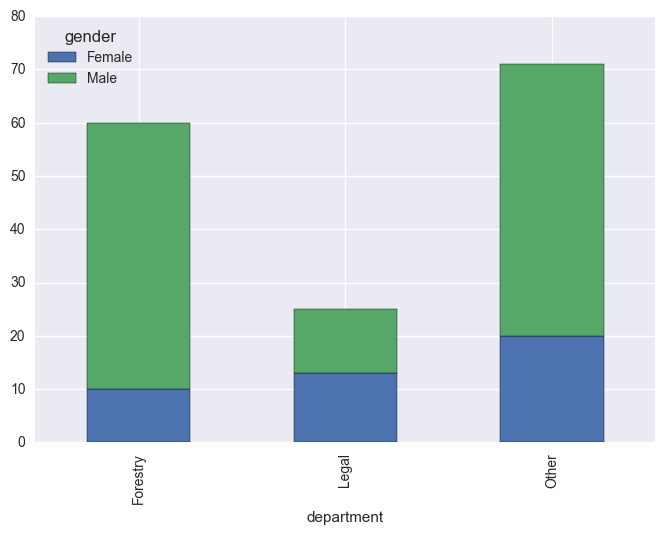

eid
department gender     
Forestry   Female   10
           Male     50
Legal      Female   13
           Male     12
Other      Female   20
           Male     51

In [15]:
#How is gender distributed across departments?
import matplotlib.pyplot as plt
dep_gender = pd.DataFrame(EmployeeBase_df.groupby(['department','gender'])['eid'].count())
dep_gender
import seaborn as sns
plot = EmployeeBase_df.groupby(['department', 'gender']).size().unstack().plot(kind='bar', stacked=True)
plt.plot
plt.show()
dep_gender

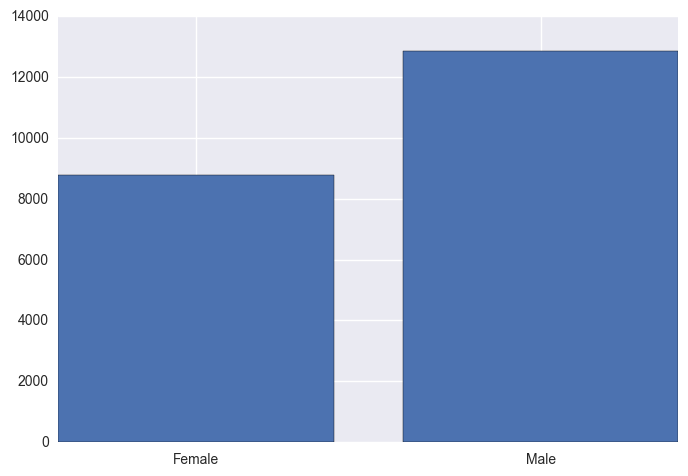

,gender,num_emails_sent
0,Female,8794
1,Male,12841


In [16]:
#Who is sending more emails? Men or Women?  MEN
query = '''
select gender, count(*) as 'num_emails_sent'
from MessageBase
join EmployeeBase on EmployeeBase.eid = MessageBase.from_eid
group by gender
'''
message_recipient_totals = pdsql.read_sql(query,con=conn)
plt.bar(message_recipient_totals.index,message_recipient_totals['num_emails_sent'],tick_label=message_recipient_totals['gender'], align='center' )
plt.show()
message_recipient_totals

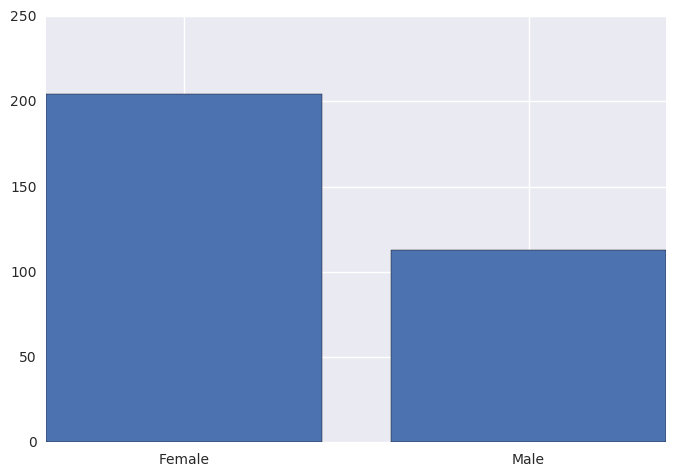

,gender,emails_sent,num_of_gender_employed,avg_emails_sent
0,Female,8794,43,204
1,Male,12841,113,113


In [241]:
#What's the average number of emails sent by each gender?
query = '''
select gender, count(MessageBase.mid) as 'emails_sent', count(distinct(eid)) as 'num_of_gender_employed', count(MessageBase.mid)/count(distinct(eid)) as 'avg_emails_sent'
from EmployeeBase
left join MessageBase on EmployeeBase.eid = MessageBase.from_eid
group by gender
'''
message_recipient_totals = pdsql.read_sql(query,con=conn)
plt.bar(message_recipient_totals.index,message_recipient_totals['avg_emails_sent'],tick_label=message_recipient_totals['gender'], align='center' )
plt.show()
message_recipient_totals

In [248]:
#Are there more Juniors or Seniors? #JUNIORS
EmployeeBase_df['seniority'].value_counts()

Junior    82
Senior    74
Name: seniority, dtype: int64

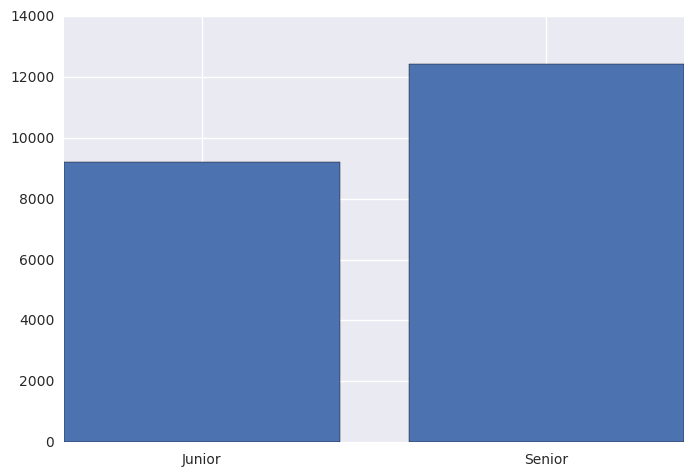

,seniority,num_emails_sent
0,Junior,9196
1,Senior,12439


In [249]:
#Who is sending more emails? Juniors or Seniors? SENIORS
query = '''
select seniority, count(*) as 'num_emails_sent'
from MessageBase
join EmployeeBase on EmployeeBase.eid = MessageBase.from_eid
group by seniority
'''
message_recipient_totals = pdsql.read_sql(query,con=conn)
plt.bar(message_recipient_totals.index,message_recipient_totals['num_emails_sent'],tick_label=message_recipient_totals['seniority'], align='center' )
plt.show()
message_recipient_totals

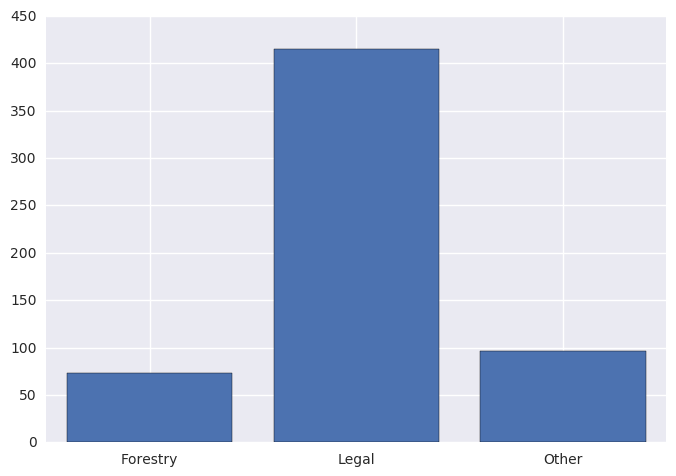

,department,emails_sent,num_of_dept_employees,avg_emails_sent
0,Forestry,4387,60,73
1,Legal,10396,25,415
2,Other,6852,71,96


In [251]:
Which department is sending more emails? How does that relate with the number of employees in the department?
query = '''
select department, count(MessageBase.mid) as 'emails_sent', count(distinct(eid)) as 'num_of_dept_employees', count(MessageBase.mid)/count(distinct(eid)) as 'avg_emails_sent'
from EmployeeBase
left join MessageBase on EmployeeBase.eid = MessageBase.from_eid
group by department
'''
message_recipient_totals = pdsql.read_sql(query,con=conn)
plt.bar(message_recipient_totals.index,message_recipient_totals['avg_emails_sent'],tick_label=message_recipient_totals['department'], align='center' )
plt.show()
message_recipient_totals

In [258]:
#Who are the top 3 senders of emails? (people who sent out the most emails)

query = '''
select eid, name, title, count(MessageBase.mid) as 'emails_sent'
from EmployeeBase
left join MessageBase on EmployeeBase.eid = MessageBase.from_eid
group by eid
order by count(MessageBase.mid) desc
limit 3
'''
message_recipient_totals = pdsql.read_sql(query,con=conn)
message_recipient_totals

,eid,name,title,emails_sent
0,20,Jeff Dasovich,Director,1597
1,59,Tana Jones,Specialist Legal,1379
2,120,Sara Shackleton,Gen Cnsl Asst,1142


Answer the following questions regarding received messages:

- Who is receiving more emails? Men or Women?
- Who is receiving more emails? Juniors or Seniors?
- Which department is receiving more emails? How does that relate with the number of employees in the department?
- Who are the top 5 receivers of emails? (people who received the most emails)

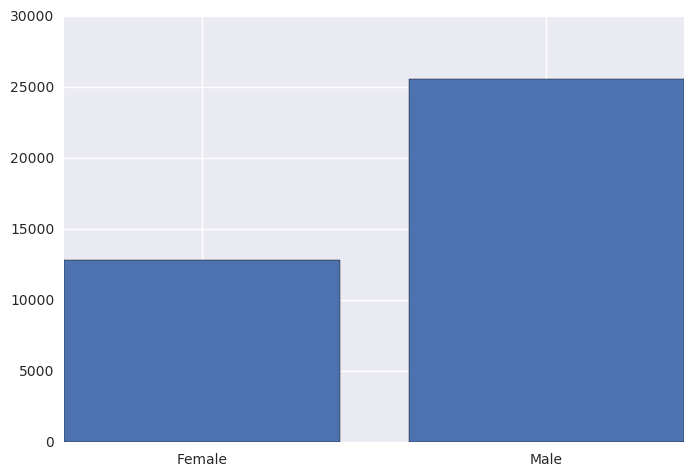

,gender,num_emails_recieved
0,Female,12839
1,Male,25549


In [262]:
#Who is receiving more emails? Men or Women?  MEN
query = '''
select gender, count(*) as 'num_emails_recieved'
from RecipientBase
join EmployeeBase on EmployeeBase.eid = RecipientBase.to_eid
group by gender
'''
message_recipient_totals = pdsql.read_sql(query,con=conn)
plt.bar(message_recipient_totals.index,message_recipient_totals['num_emails_recieved'],tick_label=message_recipient_totals['gender'], align='center' )
plt.show()
message_recipient_totals

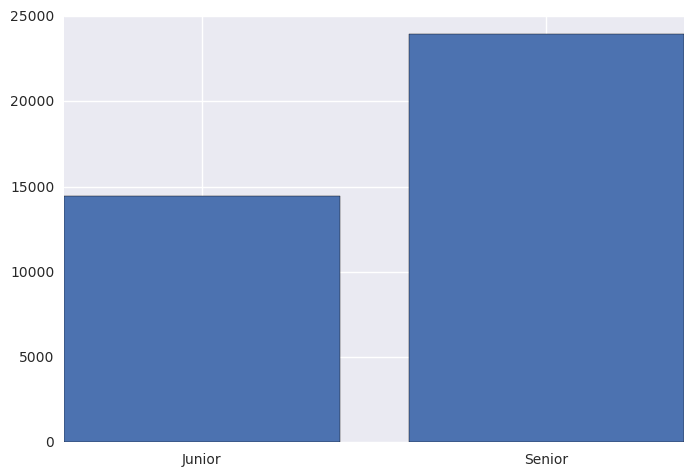

,seniority,num_emails_recieved
0,Junior,14454
1,Senior,23934


In [267]:
#Who is receiving more emails? Juniors or Seniors?
query = '''
select seniority, count(*) as 'num_emails_recieved'
from RecipientBase
join EmployeeBase on EmployeeBase.eid = RecipientBase.to_eid
group by seniority
'''
message_recipient_totals = pdsql.read_sql(query,con=conn)
plt.bar(message_recipient_totals.index,message_recipient_totals['num_emails_recieved'],tick_label=message_recipient_totals['seniority'], align='center' )
plt.show()
message_recipient_totals


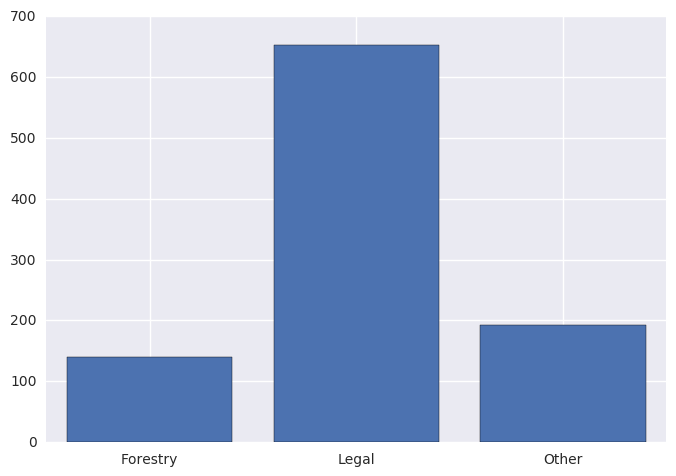

,department,emails_recieved,num_of_dept_employees,avg_emails_recieved
0,Forestry,8424,60,140
1,Legal,16311,25,652
2,Other,13653,71,192


In [269]:
#Which department is receiving more emails? How does that relate with the number of employees in the department?
query = '''
select department, count(RecipientBase.mid) as 'emails_recieved', count(distinct(eid)) as 'num_of_dept_employees', count(RecipientBase.mid)/count(distinct(eid)) as 'avg_emails_recieved'
from EmployeeBase
left join RecipientBase on EmployeeBase.eid = RecipientBase.to_eid
group by department
'''
message_recipient_totals = pdsql.read_sql(query,con=conn)
plt.bar(message_recipient_totals.index,message_recipient_totals['avg_emails_recieved'],tick_label=message_recipient_totals['department'], align='center' )
plt.show()
message_recipient_totals


In [272]:
#Who are the top 5 receivers of emails? (people who received the most emails)

query = '''
select eid, name, title, count(RecipientBase.mid) as 'emails_received'
from EmployeeBase
left join RecipientBase on EmployeeBase.eid = RecipientBase.to_eid
group by eid
order by count(RecipientBase.mid) desc
limit 5
'''
message_recipient_totals = pdsql.read_sql(query,con=conn)
message_recipient_totals

,eid,name,title,emails_received
0,131,James D. Steffes,VP of Government Affairs,1797
1,122,Richard Shapiro,VP of Regulatory Affairs,1730
2,138,Mark E. Taylor,VP & Gen Cnsl,1477
3,61,Steven J. Kean,VP & Chief of Staff,1290
4,120,Sara Shackleton,Gen Cnsl Asst,1173


Which employees sent the most 'mass' emails?

In [280]:
query = '''
select name, title, count(mid)
from

(select title, RecipientBase.mid, MessageBase.from_eid, EmployeeBase.name, count(*) as num_recipients
from RecipientBase
join MessageBase on RecipientBase.mid = MessageBase.mid 
join EmployeeBase on EmployeeBase.eid = MessageBase.from_eid
group by RecipientBase.mid, MessageBase.from_eid
having num_recipients > 10
)
group by name
order by count(mid) desc

'''
message_recipient_totals = pdsql.read_sql(query,con=conn)
message_recipient_totals.head()

,name,title,count(mid)
0,Mike Grigsby,VP Trading,59
1,James D. Steffes,VP of Government Affairs,20
2,Mary Hain,Director,19
3,John J. Lavorato,ENA President & CEO,17
4,Louise Kitchen,COO,15


Keep exploring the dataset, which other questions would you ask?

Work in pairs. Give each other a challenge and try to solve it.